# 🔍 GitHub Activity Explorer: A Data Science Journey Through Your GitHub History

### What's This Notebook About?

This notebook is your personal archaeologist for GitHub activity - it digs through your commit history using the GitHub API and transforms raw data into delightful pandas DataFrames ready for exploration. Think of it as your personal data science playground where you can unearth patterns in your coding journey and draw your own conclusions about your developer story.

While I've crafted a guided expedition through your GitHub footprint, this notebook is ultimately your canvas. Feel free to fork, modify, or completely reimagine the analysis path - your insights, your rules!

### Safety First
Rest easy! This notebook is:
- Read-only (no accidental commits)
- Privacy-focused (your data stays yours)

### How to Use This Notebook
1. Set up your GitHub token (see instructions in [README](https://github.com/poacosta/github-activity-explorer/blob/main/README.md))
2. Choose your analysis timeframe
3. Explore your coding habits with data science magic ✨


Enjoy it! - [Pedro Acosta](https://github.com/poacosta), Dec. 2024

---

*Note: Although the notebook is quite intuitive, I recommend opening the [README](https://github.com/poacosta/github-activity-explorer/blob/main/README.md) in another tab.*

In [58]:
# @title Notebook settings

# Import ENV vars from Google Colab
from google.colab import userdata

# Set up parameters
github_token = userdata.get('GITHUB_TOKEN')
start_date = '2024-01-01'
end_date = '2024-12-31'

## Code

In [59]:
# @title GitHub Configuration, Analyzer, API Client, and Support Classes

import logging
from dataclasses import dataclass
from datetime import datetime
from typing import Any, Dict, Iterator, List, Optional, Union

import pandas as pd
import requests
from requests.adapters import HTTPAdapter, Retry

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


class GitHubError(Exception):
    """Base exception for GitHub-related errors"""
    pass


class RepositoryError(GitHubError):
    """Raised when there are issues with repository access or state"""
    pass


class ConflictError(RepositoryError):
    """Raised when GitHub returns a 409 Conflict"""
    pass


class RateLimitError(GitHubError):
    """Raised when GitHub API rate limit is exceeded"""
    pass


class AuthenticationError(GitHubError):
    """Raised when GitHub API authentication fails"""
    pass


@dataclass(frozen=True)
class GitHubConfig:
    """Configuration for GitHub API access with immutable attributes"""
    token: str
    username: str
    base_url: str = "https://api.github.com"
    retry_attempts: int = 3
    timeout: int = 30

    @classmethod
    def from_environment(cls, token: str) -> 'GitHubConfig':
        """
        Create configuration from environment variables.

        Args:
            token: GitHub API token

        Returns:
            GitHubConfig instance

        Raises:
            AuthenticationError: If GitHub API authentication fails
        """
        try:
            session = create_github_session(token)
            response = session.get("https://api.github.com/user")
            response.raise_for_status()
            username = response.json()['login']
        except requests.exceptions.RequestException as e:
            raise AuthenticationError("Failed to authenticate with GitHub API") from e

        return cls(
            token=token,
            username=username
        )


def create_github_session(token: str) -> requests.Session:
    """
    Create a request session with retry logic and proper headers.

    Args:
        token: GitHub API token

    Returns:
        Configured requests.Session instance
    """
    session = requests.Session()

    retries = Retry(
        total=3,
        backoff_factor=0.5,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=["GET"]
    )

    session.mount('https://', HTTPAdapter(max_retries=retries))
    session.headers.update({
        "Authorization": f"Bearer {token}",
        "Accept": "application/vnd.github+json",
        "X-GitHub-Api-Version": "2022-11-28"
    })

    return session


class GitHubAPIClient:
    """Base client for making GitHub API requests"""

    def __init__(self, config: GitHubConfig):
        self.config = config
        self.session = create_github_session(config.token)

    def _paginate(self, url: str, params: Optional[Dict] = None) -> Iterator[List[Dict[str, Any]]]:
        """
        Generic pagination handler for GitHub API.

        Args:
            url: API endpoint URL
            params: Optional query parameters

        Yields:
            Batches of API response data

        Raises:
            RateLimitError: If rate limit is exceeded
            GitHubError: For other GitHub API errors
        """
        params = params or {}
        page = 1

        while True:
            try:
                response = self.session.get(
                    url,
                    params={**params, "page": page, "per_page": 100},
                    timeout=self.config.timeout
                )

                if response.status_code == 403 and 'X-RateLimit-Remaining' in response.headers:
                    if int(response.headers['X-RateLimit-Remaining']) == 0:
                        raise RateLimitError("GitHub API rate limit exceeded")

                response.raise_for_status()
                batch = response.json()

                if not batch:
                    break

                yield batch
                page += 1

            except requests.exceptions.RequestException as e:
                raise GitHubError(f"GitHub API request failed: {str(e)}") from e


class GitHubAnalyzer(GitHubAPIClient):
    """Class to analyze GitHub activity across organizations and repositories"""

    def _check_repository_status(self, repo_full_name: str) -> bool:
        """
        Check if a repository is accessible and contains commits.

        Args:
            repo_full_name: Full repository name (owner/repo)

        Returns:
            bool: True if repository is valid and accessible

        Raises:
            RepositoryError: If repository is not accessible
            ConflictError: If repository state is invalid
        """
        try:
            response = self.session.get(
                f"{self.config.base_url}/repos/{repo_full_name}",
                timeout=self.config.timeout
            )
            response.raise_for_status()

            repo_data = response.json()
            if repo_data.get('size', 0) == 0:
                # logger.warning("Repository %s is empty", repo_full_name)
                return False

            if repo_data.get('archived', False):
                # logger.warning("Repository %s is archived", repo_full_name)
                return False

            return True

        except requests.exceptions.HTTPError as e:
            if e.response.status_code == 409:
                logger.warning("Repository %s is in an invalid state", repo_full_name)
                return False
            elif e.response.status_code == 404:
                logger.warning("Repository %s not found", repo_full_name)
                return False
            raise RepositoryError(f"Failed to check repository status: {str(e)}") from e
        except requests.exceptions.RequestException as e:
            raise RepositoryError(f"Failed to check repository status: {str(e)}") from e

    def get_commit_details(self, repo_full_name: str, commit_sha: str) -> Dict[str, Any]:
        """
        Get detailed information about a specific commit.

        Args:
            repo_full_name: Full repository name (owner/repo)
            commit_sha: Commit SHA

        Returns:
            Dictionary containing commit details

        Raises:
            GitHubError: If API request fails
        """
        try:
            response = self.session.get(
                f"{self.config.base_url}/repos/{repo_full_name}/commits/{commit_sha}",
                timeout=self.config.timeout,
                headers={**self.session.headers, "Accept": "application/vnd.github.v3.full+json"}
            )
            response.raise_for_status()
            return response.json()
        except Exception as e:
            logger.warning("Failed to fetch commit details for %s/%s: %s", repo_full_name, commit_sha, str(e))
            return {}

    def get_user_repos(self) -> List[Dict]:
        """
        Fetch all repositories the user has access to.

        Returns:
            List of repository data dictionaries

        Raises:
            GitHubError: If API request fails
        """
        repos = []
        try:
            for batch in self._paginate(
                    f"{self.config.base_url}/user/repos",
                    params={
                        "affiliation": "owner,collaborator,organization_member,outside",
                        "visibility": "all",
                        "sort": "fullname",
                        "direction": "desc"
                    }
            ):
                repos.extend(batch)
            return repos
        except Exception as e:
            logger.error("Failed to fetch user repositories: %s", str(e))
            raise

    def get_user_orgs(self) -> List[str]:
        """
        Fetch all organizations the user belongs to.

        Returns:
            List of organization login names

        Raises:
            GitHubError: If API request fails
        """
        orgs = []
        try:
            for batch in self._paginate(f"{self.config.base_url}/user/orgs"):
                orgs.extend(org["login"] for org in batch)
            return orgs
        except Exception as e:
            logger.error("Failed to fetch user organizations: %s", str(e))
            raise

    def get_org_repos(self, org: str) -> List[Dict]:
        """
        Fetch all repositories for a given organization.

        Args:
            org: Organization login name

        Returns:
            List of repository data dictionaries

        Raises:
            GitHubError: If API request fails
        """
        repos = []
        try:
            for batch in self._paginate(
                    f"{self.config.base_url}/orgs/{org}/repos",
                    params={"type": "all"}
            ):
                repos.extend(batch)
            return repos
        except Exception as e:
            logger.error("Failed to fetch repositories for org %s: %s", org, str(e))
            raise

    def get_commit_activity(
            self,
            repo_full_name: str,
            start_date: Union[str, datetime],
            end_date: Union[str, datetime]
    ) -> pd.DataFrame:
        """
        Fetch commit activity for a specific repository within date range.

        Args:
            repo_full_name: Full repository name (owner/repo)
            start_date: Start date for commit range
            end_date: End date for commit range

        Returns:
            DataFrame containing commit data

        Raises:
            GitHubError: If API request fails
        """
        if not self._check_repository_status(repo_full_name):
            logger.info("Skipping repository %s due to invalid state", repo_full_name)
            return pd.DataFrame()

        commits = []
        try:
            for batch in self._paginate(
                    f"{self.config.base_url}/repos/{repo_full_name}/commits",
                    params={
                        "since": pd.Timestamp(start_date).isoformat(),
                        "until": pd.Timestamp(end_date).isoformat(),
                        "author": self.config.username
                    }
            ):
                commits.extend(batch)

            if not commits:
                return pd.DataFrame()

            commit_data = []
            for commit in commits:
                if (commit.get('author') and
                        commit.get('commit', {}).get('author') and
                        commit['author']['login'] == self.config.username):
                    # Get detailed commit information
                    commit_details = self.get_commit_details(repo_full_name, commit['sha'])

                    commit_date = pd.to_datetime(commit['commit']['author']['date'])

                    commit_data.append({
                        'hash': commit['sha'],
                        'author': commit['author']['login'],
                        'date': commit_date,
                        'message': commit['commit']['message'],
                        'repository': repo_full_name,
                        'additions': commit_details.get('stats', {}).get('additions', 0),
                        'deletions': commit_details.get('stats', {}).get('deletions', 0),
                        'files_changed': len(commit_details.get('files', []))
                    })

            return pd.DataFrame(commit_data)

        except Exception as e:
            logger.error("Failed to fetch commit activity for %s: %s", repo_full_name, str(e))
            raise

    def analyze_commit_patterns(
            self,
            start_date: Union[str, datetime],
            end_date: Union[str, datetime],
            include_personal: bool = True,
            include_org: bool = True
    ) -> pd.DataFrame:
        """
        Analyze commit patterns across repositories.

        Args:
            start_date: Start date for analysis
            end_date: End date for analysis
            include_personal: Whether to include personal repositories
            include_org: Whether to include organization repositories

        Returns:
            DataFrame containing consolidated commit data

        Raises:
            GitHubError: If API request fails
        """
        all_commits = pd.DataFrame()

        try:
            if include_personal:
                personal_repos = self.get_user_repos()
                for repo in personal_repos:
                    repo_commits = self.get_commit_activity(
                        repo['full_name'],
                        start_date,
                        end_date
                    )
                    all_commits = pd.concat([all_commits, repo_commits])

            if include_org:
                for org in self.get_user_orgs():
                    org_repos = self.get_org_repos(org)
                    for repo in org_repos:
                        repo_commits = self.get_commit_activity(
                            repo['full_name'],
                            start_date,
                            end_date
                        )
                        all_commits = pd.concat([all_commits, repo_commits])

            return all_commits.reset_index(drop=True)

        except Exception as e:
            logger.error("Failed to analyze commit patterns: %s", str(e))
            raise


def initialize_analysis(github_token: str, start_date: str, end_date: str):
    """
    Initialize GitHub analyzer and fetch commit data.

    Args:
        github_token: GitHub personal access token
        start_date: Start date in YYYY-MM-DD format
        end_date: End date in YYYY-MM-DD format

    Returns:
        Tuple of (GitHubAnalyzer, pandas DataFrame)
    """
    try:
        config = GitHubConfig.from_environment(github_token)
        logger.info("Successfully authenticated with GitHub")

        analyzer = GitHubAnalyzer(config)

        logger.info(f"Analyzing commits between {start_date} and {end_date}")
        commits_df = analyzer.analyze_commit_patterns(
            start_date=start_date,
            end_date=end_date,
            include_personal=True,
            include_org=True
        )

        logger.info(f"Found {len(commits_df)} commits across all repositories")
        return analyzer, commits_df

    except AuthenticationError:
        logger.error("Failed to authenticate with GitHub. Please check your token.")
        raise
    except Exception as e:
        logger.error(f"Error during analysis initialization: {str(e)}")
        raise


In [60]:
# @title Standalone methods

from datetime import datetime
from typing import Dict, Any, Union

import pandas as pd
import pytz


def get_unique_commits(commits_df: pd.DataFrame) -> pd.DataFrame:
    """
    Get unique commits based on hash, removing any duplicates.

    Args:
        commits_df: DataFrame containing commit data

    Returns:
        DataFrame with unique commits only
    """
    if commits_df.empty:
        return commits_df

    return commits_df.drop_duplicates(subset=['hash']).copy()


def get_commit_summary(commits_df: pd.DataFrame) -> Dict[str, Any]:
    """
    Generate a summary of commit statistics.

    Args:
        commits_df: DataFrame containing commit data

    Returns:
        Dictionary containing summary statistics
    """
    if commits_df.empty:
        return {
            'total_commits': 0,
            'unique_commits': 0,
            'total_additions': 0,
            'total_deletions': 0,
            'total_files_changed': 0,
            'repositories': [],
            'date_range': None
        }

    unique_commits = get_unique_commits(commits_df)

    return {
        'total_commits': len(commits_df),
        'unique_commits': len(unique_commits),
        'total_additions': unique_commits['additions'].sum(),
        'total_deletions': unique_commits['deletions'].sum(),
        'total_files_changed': unique_commits['files_changed'].sum(),
        'repositories': unique_commits['repository'].unique().tolist(),
        'date_range': {
            'first_commit': unique_commits['date'].min(),
            'last_commit': unique_commits['date'].max()
        }
    }


def get_commit_patterns_by_time(commits_df: pd.DataFrame, freq: str = 'D') -> pd.DataFrame:
    """
    Analyze commit patterns aggregated by time frequency.

    Args:
        commits_df: DataFrame containing commit data
        freq: Frequency for resampling ('D' for daily, 'W' for weekly, 'ME' for monthly)

    Returns:
        DataFrame with commit patterns by time period
    """
    if commits_df.empty:
        return pd.DataFrame()

    unique_commits = get_unique_commits(commits_df)

    # Resample by specified frequency
    patterns = unique_commits.set_index('date').resample(freq).agg({
        'hash': 'count',
        'additions': 'sum',
        'deletions': 'sum',
        'files_changed': 'sum'
    }).reset_index()

    # Rename columns for clarity
    patterns = patterns.rename(columns={
        'hash': 'commit_count',
        'additions': 'lines_added',
        'deletions': 'lines_deleted',
        'files_changed': 'files_modified'
    })

    return patterns


def get_repository_stats(commits_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate statistics per repository.

    Args:
        commits_df: DataFrame containing commit data

    Returns:
        DataFrame with repository-level statistics
    """
    if commits_df.empty:
        return pd.DataFrame()

    unique_commits = get_unique_commits(commits_df)

    repo_stats = unique_commits.groupby('repository').agg({
        'hash': 'count',
        'additions': 'sum',
        'deletions': 'sum',
        'files_changed': 'sum',
        'date': ['min', 'max']
    }).reset_index()

    # Flatten multi-level columns
    repo_stats.columns = ['repository', 'commit_count', 'lines_added',
                          'lines_deleted', 'files_modified', 'first_commit', 'last_commit']

    # Calculate net changes
    repo_stats['net_changes'] = repo_stats['lines_added'] - repo_stats['lines_deleted']

    # Sort by commit count
    return repo_stats.sort_values('commit_count', ascending=False)


def convert_to_timezone(
        data: Union[pd.DataFrame, pd.Series, datetime],
        timezone: str = 'UTC',
        date_column: str = 'date'
) -> Union[pd.DataFrame, pd.Series, datetime]:
    """
    Convert dates to a specific timezone, handling both tz-naive and tz-aware datetimes.

    Args:
        data: DataFrame with date column, Series of dates, or single datetime
        timezone: Target timezone (e.g., 'America/New_York', 'Europe/London', 'Asia/Tokyo')
        date_column: Name of the date column if data is DataFrame

    Returns:
        Data with converted timezone
    """
    try:
        target_tz = pytz.timezone(timezone)
    except pytz.exceptions.UnknownTimeZoneError:
        raise ValueError(f"Invalid timezone: {timezone}. Use a valid timezone from the pytz database.")

    if isinstance(data, pd.DataFrame):
        df = data.copy()
        if date_column not in df.columns:
            raise ValueError(f"Column '{date_column}' not found in DataFrame")

        is_tz_aware = df[date_column].dt.tz is not None

        if is_tz_aware:
            df[date_column] = df[date_column].dt.tz_convert(target_tz)
        else:
            df[date_column] = df[date_column].dt.tz_localize('UTC').dt.tz_convert(target_tz)
        return df

    elif isinstance(data, pd.Series):
        is_tz_aware = data.dt.tz is not None
        if is_tz_aware:
            return data.dt.tz_convert(target_tz)
        return data.dt.tz_localize('UTC').dt.tz_convert(target_tz)

    elif isinstance(data, datetime):
        if data.tzinfo is not None:
            return data.astimezone(target_tz)
        return pytz.UTC.localize(data).astimezone(target_tz)

    else:
        raise TypeError("Input must be a DataFrame, Series, or datetime object")


In [61]:
# @title Utils

import csv

import pandas as pd


def export_dataframe_to_csv(
        df: pd.DataFrame,
        output_path: str,
        encoding: str = 'utf-8',
        index: bool = False,
        date_format: str = '%Y-%m-%d %H:%M:%S'
) -> None:
    """
    Export a pandas DataFrame to CSV while preserving the original data types and formats.

    Args:
        df (pd.DataFrame): The DataFrame to export
        output_path (str): Path where the CSV file will be saved
        encoding (str, optional): File encoding. Default to 'utf-8'
        index (bool, optional): Whether to write row names (index). Default to False
        date_format (str, optional): Format string for datetime objects.
            Defaults to '%Y-%m-%d %H:%M:%S'

    Returns:
        None

    Raises:
        OSError: If there are issues writing to the specified path
        ValueError: If the DataFrame is empty
    """
    if df.empty:
        raise ValueError("Cannot export empty DataFrame")

    try:
        df.to_csv(
            path_or_buf=output_path,
            encoding=encoding,
            index=index,
            date_format=date_format,
            float_format='%.6g',
            quoting=csv.QUOTE_NONNUMERIC,
            escapechar='\\',
            na_rep='',
        )
    except OSError as e:
        raise OSError(f"Failed to write CSV to {output_path}: {str(e)}")


## Initialize and run analysis

In [62]:
analyzer, commits_df = initialize_analysis(
    github_token=github_token,
    start_date=start_date,
    end_date=end_date
)

## Stats

In [63]:
# @title Commit Summary

# Get unique commits
unique_commits = get_unique_commits(commits_df)
print(f"\nUnique commits: {len(unique_commits)}")

# Get overall summary
summary = get_commit_summary(commits_df)
print("\nCommit Summary:")
print(f"Total commits: {summary['total_commits']}")
print(f"Unique commits: {summary['unique_commits']}")
print(f"Total additions: {summary['total_additions']}")
print(f"Total deletions: {summary['total_deletions']}")


Unique commits: 92

Commit Summary:
Total commits: 103
Unique commits: 92
Total additions: 105672
Total deletions: 3784


In [64]:
# @title Commits

commits_df

,hash,author,date,message,repository,additions,deletions,files_changed
0,4b386c371ac915f432003d4047de22e9836535ad,poacosta,2024-12-20 17:00:42+00:00,:books:,poacosta/service-health-monitor,21,11,2
1,185b0b0d0b64081feb43a26a615344ce036d70d4,poacosta,2024-12-20 11:43:47+00:00,Optimization and Bug Fixes (#1)\n\n* Improving...,poacosta/service-health-monitor,289,50,3
2,68e51c3dd48b4b9d21c487e454e6871a03d29b36,poacosta,2024-12-20 02:14:56+00:00,Update requirements.txt,poacosta/service-health-monitor,6,1,1
3,37acb1796d35da83b0fba0dc3078865668c550a5,poacosta,2024-12-20 01:14:57+00:00,Initial commit,poacosta/service-health-monitor,753,1,9
4,c64dc3eda6674d26193f9d21d03d14f2dc0fdf61,poacosta,2024-12-19 20:55:29+00:00,Initial commit,poacosta/service-health-monitor,22,0,2
...,...,...,...,...,...,...,...,...
98,bd0b99e0465471f7950a6ce2acd02d91338b75ee,poacosta,2024-05-25 23:55:25+00:00,Microwave,poacosta/ruby-on-exercism,142,0,4
99,8f3c526bf2de7276f9278789626e10c920908555,poacosta,2024-05-25 23:25:06+00:00,Armstrong Numbers,poacosta/ruby-on-exercism,154,0,4
100,001177733f92bd0ab9fd1186b5de156b8125b3d9,poacosta,2024-02-21 14:59:12+00:00,Update README.md,poacosta/ruby-on-exercism,1,1,1
101,34d5ab3a9dc6d463881205d93b045b85dd71bf27,poacosta,2024-02-21 14:56:52+00:00,Update README.md,poacosta/ruby-on-exercism,1,1,1


In [65]:
# @title Commits at America/Monterrey

commits_df_tz = convert_to_timezone(commits_df, timezone='America/Monterrey')
commits_df_tz

,hash,author,date,message,repository,additions,deletions,files_changed
0,4b386c371ac915f432003d4047de22e9836535ad,poacosta,2024-12-20 11:00:42-06:00,:books:,poacosta/service-health-monitor,21,11,2
1,185b0b0d0b64081feb43a26a615344ce036d70d4,poacosta,2024-12-20 05:43:47-06:00,Optimization and Bug Fixes (#1)\n\n* Improving...,poacosta/service-health-monitor,289,50,3
2,68e51c3dd48b4b9d21c487e454e6871a03d29b36,poacosta,2024-12-19 20:14:56-06:00,Update requirements.txt,poacosta/service-health-monitor,6,1,1
3,37acb1796d35da83b0fba0dc3078865668c550a5,poacosta,2024-12-19 19:14:57-06:00,Initial commit,poacosta/service-health-monitor,753,1,9
4,c64dc3eda6674d26193f9d21d03d14f2dc0fdf61,poacosta,2024-12-19 14:55:29-06:00,Initial commit,poacosta/service-health-monitor,22,0,2
...,...,...,...,...,...,...,...,...
98,bd0b99e0465471f7950a6ce2acd02d91338b75ee,poacosta,2024-05-25 17:55:25-06:00,Microwave,poacosta/ruby-on-exercism,142,0,4
99,8f3c526bf2de7276f9278789626e10c920908555,poacosta,2024-05-25 17:25:06-06:00,Armstrong Numbers,poacosta/ruby-on-exercism,154,0,4
100,001177733f92bd0ab9fd1186b5de156b8125b3d9,poacosta,2024-02-21 08:59:12-06:00,Update README.md,poacosta/ruby-on-exercism,1,1,1
101,34d5ab3a9dc6d463881205d93b045b85dd71bf27,poacosta,2024-02-21 08:56:52-06:00,Update README.md,poacosta/ruby-on-exercism,1,1,1


In [66]:
# @title Commit Patterns (Monthly)

# freq: Frequency for resampling ('D' for daily, 'W' for weekly, 'ME' for monthly)
monthly_patterns = get_commit_patterns_by_time(commits_df, freq='ME')
monthly_patterns = monthly_patterns.reset_index(drop=True)
monthly_patterns.index = monthly_patterns.index + 1
monthly_patterns.date = monthly_patterns.date.dt.strftime('%Y-%m-%d')
monthly_patterns

,date,commit_count,lines_added,lines_deleted,files_modified
1,2024-01-31,1,9100,0,300
2,2024-02-29,5,760,5,11
3,2024-03-31,0,0,0,0
4,2024-04-30,0,0,0,0
5,2024-05-31,6,1019,0,24
6,2024-06-30,0,0,0,0
7,2024-07-31,2,60627,2,153
8,2024-08-31,24,8796,621,114
9,2024-09-30,38,22305,1271,203
10,2024-10-31,5,324,1822,14


In [67]:
# @title Commit Patterns (Daily)

daily_patterns = get_commit_patterns_by_time(commits_df, freq='D')
daily_patterns.date = daily_patterns.date.dt.strftime('%Y-%m-%d')
daily_patterns.sort_values('commit_count', ascending=False, inplace=True)
daily_patterns

,date,commit_count,lines_added,lines_deleted,files_modified
249,2024-09-15,8,7318,481,70
233,2024-08-30,6,7947,392,45
252,2024-09-18,6,759,9,7
227,2024-08-24,5,172,70,10
267,2024-10-03,5,324,1822,14
...,...,...,...,...,...
30,2024-02-09,0,0,0,0
31,2024-02-10,0,0,0,0
135,2024-05-24,0,0,0,0
134,2024-05-23,0,0,0,0


In [68]:
# @title Repository Stats

repo_stats = get_repository_stats(commits_df)
repo_stats.sort_values('commit_count', ascending=False, inplace=True)
repo_stats

,repository,commit_count,lines_added,lines_deleted,files_modified,first_commit,last_commit,net_changes
12,poacosta/react-intensive-training-with-js,22,62313,1992,235,2024-07-19 18:38:11+00:00,2024-10-03 23:31:01+00:00,60321
0,katiie/encode-2024-q3-grp14-storytelling-rag,11,7319,671,71,2024-09-14 17:42:20+00:00,2024-09-15 23:46:41+00:00,6648
4,poacosta/encode-2024-q3-grp14-joke-generator,9,8024,464,51,2024-08-30 06:32:50+00:00,2024-09-01 18:45:02+00:00,7560
13,poacosta/ruby-on-exercism,8,1021,2,26,2024-02-21 14:56:52+00:00,2024-05-27 06:18:04+00:00,1019
1,poacosta/animals-classifier,7,482,81,29,2024-09-20 13:10:23+00:00,2024-09-21 17:32:06+00:00,401
5,poacosta/encode-2024-q3-grp14-storytelling-app,7,7063,247,37,2024-09-07 14:57:24+00:00,2024-09-10 05:42:40+00:00,6816
10,poacosta/my-chef-gpt,7,286,70,14,2024-08-22 18:56:37+00:00,2024-08-24 11:38:28+00:00,216
14,poacosta/service-health-monitor,5,1091,63,17,2024-12-19 20:55:29+00:00,2024-12-20 17:00:42+00:00,1028
2,poacosta/custom-agent-with-llamaindex,4,579,191,8,2024-09-16 22:40:00+00:00,2024-09-20 13:01:17+00:00,388
8,poacosta/jupyter-notebooks,4,1061,0,5,2024-12-12 01:27:00+00:00,2024-12-12 12:02:09+00:00,1061


In [69]:
# @title Consider exporting to CSV—this will help you avoid hitting the GitHub API rate limit and allow you to reuse the data later.

# Export with:
# export_dataframe_to_csv(repo_stats, 'repo_stats.csv')

# then

# How to use it:
# repo_stats = pd.read_csv('repo_stats.csv', parse_dates=['first_commit', 'last_commit'])

## Playing with the data | Charts

In [70]:
# @title Import libs

import matplotlib.pyplot as plt
import seaborn as sns

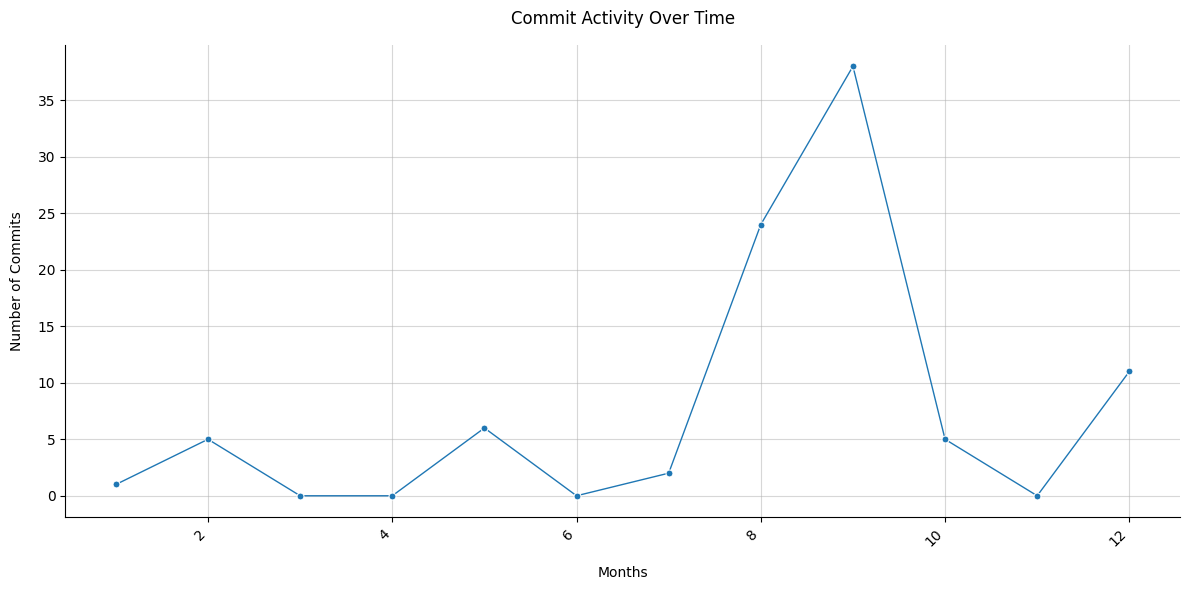

In [71]:
# @title Commit Activity Over Time

plt.figure(figsize=(12, 6), dpi=100)
sns.lineplot(
    data=monthly_patterns,
    x=monthly_patterns.index,
    y='commit_count',
    linewidth=1,
    marker='o',
    markersize=5
)
plt.title('Commit Activity Over Time', fontsize=12, pad=15)
plt.xlabel('Months', fontsize=10, labelpad=12)
plt.ylabel('Number of Commits', fontsize=10, labelpad=10)
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.tight_layout()
plt.grid(True, linestyle='-', alpha=0.5)
plt.show()

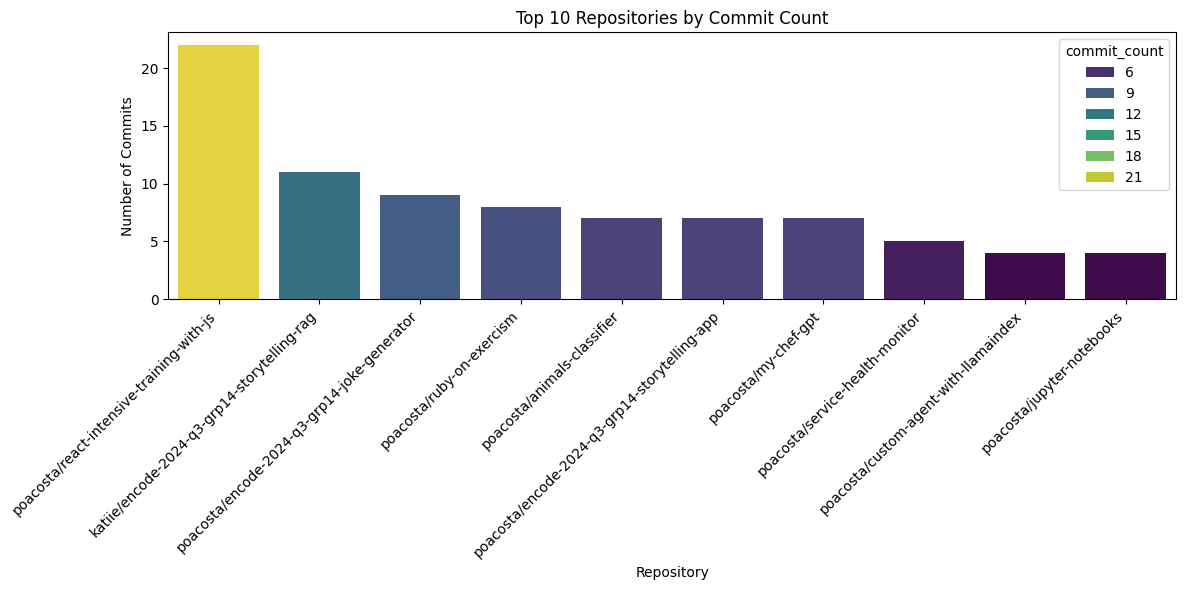

In [72]:
# @title Top 10 Repositories by Commit Count

top_10_repos = repo_stats.sort_values('commit_count', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='repository', y='commit_count', data=top_10_repos, palette='viridis', hue='commit_count')
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Repositories by Commit Count')
plt.xlabel('Repository')
plt.ylabel('Number of Commits')
plt.tight_layout()
plt.show()

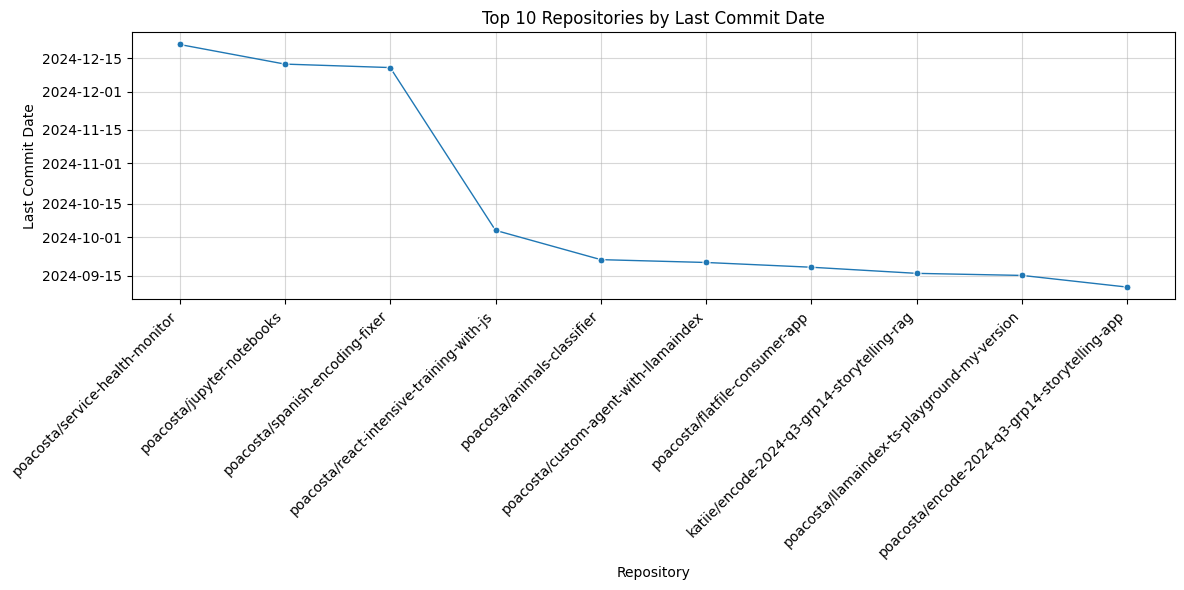

In [73]:
# @title Top 10 Repositories by Last Commit Date

top_10_repos_by_last_commit = repo_stats.sort_values('last_commit', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.lineplot(x='repository', y='last_commit', data=top_10_repos_by_last_commit,   linewidth=1,
    marker='o',
    markersize=5)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Repositories by Last Commit Date')
plt.xlabel('Repository')
plt.ylabel('Last Commit Date')
plt.grid(True, linestyle='-', alpha=0.5)
plt.tight_layout()
plt.show()

In [74]:
# Work your magic...